# Transfer Learning con EfficientNetV2-S - Versión 1 (V1)

Proyecto de clasificación de frutas y verduras usando Transfer Learning con EfficientNetV2-S.

**Características de la Versión 1:**
- Modelo base: EfficientNetV2-S preentrenado
- Clasificador simple: una sola capa Fully Connected
- Sin Batch Normalization adicional
- Sin Dropout
- Sin capas ocultas adicionales
- Early stopping basado en validation loss

## SECCION 1 - Imports y Configuracion

Importacion de librerias necesarias y configuracion del dispositivo (GPU/CPU)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import time
import copy
import warnings
warnings.filterwarnings('ignore')

# Configuracion del dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Dispositivo utilizado: {device}')

# Configuracion para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Dispositivo utilizado: cuda


In [2]:
# Importar funciones de procesamiento de datos
from utils.data_proccess import create_transforms, load_datasets, create_dataloaders

### 3.1 - Configuracion y Carga de Datos

In [3]:
# Configuracion del proyecto
data_dir = "datos"
img_size = 224
batch_size = 32

# Crear transformaciones
print("Creando transformaciones...")
train_transform, val_test_transform = create_transforms(img_size=img_size)

# Cargar datasets
print("Cargando datasets...")
train_dataset, val_dataset, test_dataset = load_datasets(
    data_dir, train_transform, val_test_transform
)

# Mostrar informacion de las clases
print(f"\nClases detectadas: {train_dataset.classes}")
print(f"Numero de clases: {len(train_dataset.classes)}")
print(f"Muestras de entrenamiento: {len(train_dataset)}")
print(f"Muestras de validacion: {len(val_dataset)}")
print(f"Muestras de test: {len(test_dataset)}")

# Crear DataLoaders
print("\nCreando DataLoaders...")
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, batch_size=batch_size
)

print(f"Batches de entrenamiento: {len(train_loader)}")
print(f"Batches de validacion: {len(val_loader)}")
print(f"Batches de test: {len(test_loader)}")

# Guardar variables importantes
class_names = train_dataset.classes
num_classes = len(class_names)

Creando transformaciones...
Cargando datasets...

Clases detectadas: ['carrot', 'chilli pepper', 'corn', 'cucumber', 'jalepeno']
Numero de clases: 5
Muestras de entrenamiento: 438
Muestras de validacion: 47
Muestras de test: 50

Creando DataLoaders...
Batches de entrenamiento: 14
Batches de validacion: 2
Batches de test: 2


In [4]:
from utils.train_model import train_model, plot_training_metrics
from utils.evaluate_model import evaluate_model

In [5]:
def build_model_v1(num_classes):
    """
    Construye el modelo EfficientNetV2-S V1 con transfer learning
    
    Args:
        num_classes (int): Numero de clases para el clasificador
    
    Returns:
        model: Modelo EfficientNetV2-S modificado para V1
    """
    # Cargar modelo preentrenado
    model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
    
    # Congelar todas las capas del feature extractor
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Obtener el numero de features de entrada del clasificador
    in_features = model.classifier[1].in_features
    
    # Reemplazar el clasificador con una sola capa Linear (V1)
    # Sin BatchNorm, sin Dropout, sin capas ocultas adicionales
    model.classifier = nn.Linear(in_features, num_classes)
    
    print(f"Modelo EfficientNetV2-S V1 creado exitosamente")
    print(f"Features de entrada del clasificador: {in_features}")
    print(f"Clases de salida: {num_classes}")
    print(f"Arquitectura V1: Una sola capa Linear({in_features} -> {num_classes})")
    
    return model

In [6]:
# Construir modelo V1
print("Construyendo modelo EfficientNetV2-S V1...")
model = build_model_v1(num_classes)
model = model.to(device)

# Mostrar arquitectura del clasificador
print(f"\nArquitectura del clasificador:")
print(model.classifier)

# Verificar parametros entrenables
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"\nParametros totales: {total_params:,}")
print(f"Parametros entrenables: {trainable_params:,}")
print(f"Parametros congelados: {total_params - trainable_params:,}")
print(f"Porcentaje entrenables: {(trainable_params/total_params)*100:.2f}%")

# Configurar criterion y optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"\nConfiguración del entrenamiento:")
print(f"Loss function: CrossEntropyLoss")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Early stopping: activado (patience=5)")

Construyendo modelo EfficientNetV2-S V1...
Modelo EfficientNetV2-S V1 creado exitosamente
Features de entrada del clasificador: 1280
Clases de salida: 5
Arquitectura V1: Una sola capa Linear(1280 -> 5)

Arquitectura del clasificador:
Linear(in_features=1280, out_features=5, bias=True)

Parametros totales: 20,183,893
Parametros entrenables: 6,405
Parametros congelados: 20,177,488
Porcentaje entrenables: 0.03%

Configuración del entrenamiento:
Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001)
Early stopping: activado (patience=5)


### 3.3 - Entrenamiento con Early Stopping

In [7]:
# Entrenar el modelo
num_epochs = 10
patience = 5

print("="*60)
print("ENTRENAMIENTO DEL MODELO EFFICIENTNETV2-S V1")
print("="*60)

trained_model, train_losses, val_losses, train_accuracies, val_accuracies, best_epoch = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    patience=patience,
    device=device
)

print("\n" + "="*60)
print("ENTRENAMIENTO COMPLETADO")
print("="*60)

ENTRENAMIENTO DEL MODELO EFFICIENTNETV2-S V1
Iniciando entrenamiento...
Device: cuda
Epochs maximos: 10
Early stopping patience: 5
------------------------------------------------------------
Epoch 1/10 - Batch 10/14 - Loss: 1.2480 - Acc: 42.81%
Epoch 1/10 completado en 9.79s
Train - Loss: 1.3618, Acc: 51.83%
Val   - Loss: 1.0713, Acc: 80.85%
🌟 Nuevo mejor modelo! Val Loss: 1.0713, Val Acc: 80.85%
------------------------------------------------------------
Epoch 2/10 - Batch 10/14 - Loss: 0.9767 - Acc: 83.44%
Epoch 2/10 completado en 9.49s
Train - Loss: 0.8626, Acc: 84.02%
Val   - Loss: 0.6211, Acc: 89.36%
🌟 Nuevo mejor modelo! Val Loss: 0.6211, Val Acc: 89.36%
------------------------------------------------------------
Epoch 3/10 - Batch 10/14 - Loss: 0.6519 - Acc: 88.44%
Epoch 3/10 completado en 9.61s
Train - Loss: 0.6230, Acc: 88.36%
Val   - Loss: 0.4511, Acc: 93.62%
🌟 Nuevo mejor modelo! Val Loss: 0.4511, Val Acc: 93.62%
-----------------------------------------------------------

### 3.4 - Visualizacion de Curvas de Perdida

Generando gráficas de métricas de entrenamiento...


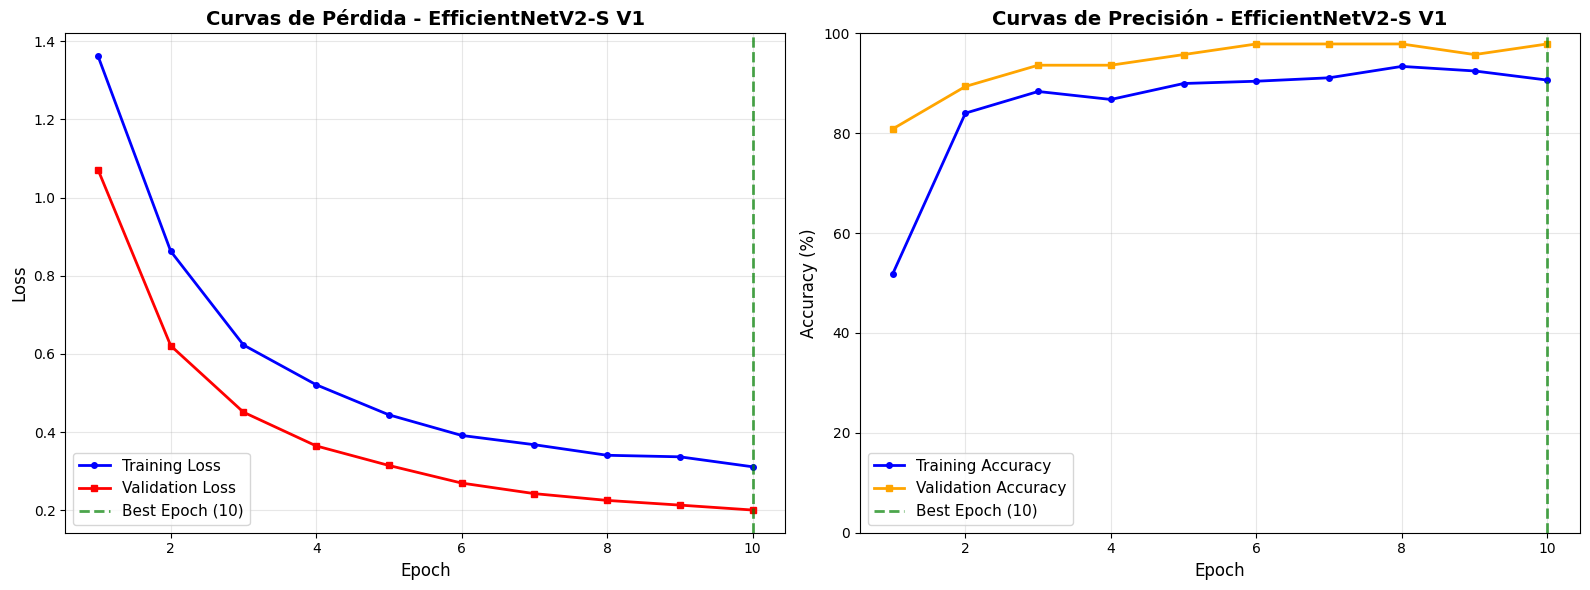

📊 RESUMEN DE MÉTRICAS:
📈 LOSS:
  • Final training loss:     0.3115
  • Final validation loss:   0.2010
  • Best validation loss:    0.2010 (epoch 10)
📊 ACCURACY:
  • Final training accuracy:     90.64%
  • Final validation accuracy:   97.87%
  • Best validation accuracy:    97.87% (epoch 6)
⭐ MEJOR MODELO (Epoch 10):
  • Validation loss:     0.2010
  • Validation accuracy: 97.87%


In [8]:
# Graficar curvas de perdida
print("Generando gráficas de métricas de entrenamiento...")
plot_training_metrics(train_losses, val_losses, train_accuracies, val_accuracies, best_epoch)

### 3.5 - Evaluacion Final en Conjunto de Test

EVALUACION FINAL EN CONJUNTO DE TEST
Evaluando modelo en conjunto de test...

Resultados de evaluacion:
Accuracy total: 0.9800 (98.00%)
Muestras correctas: 49/50


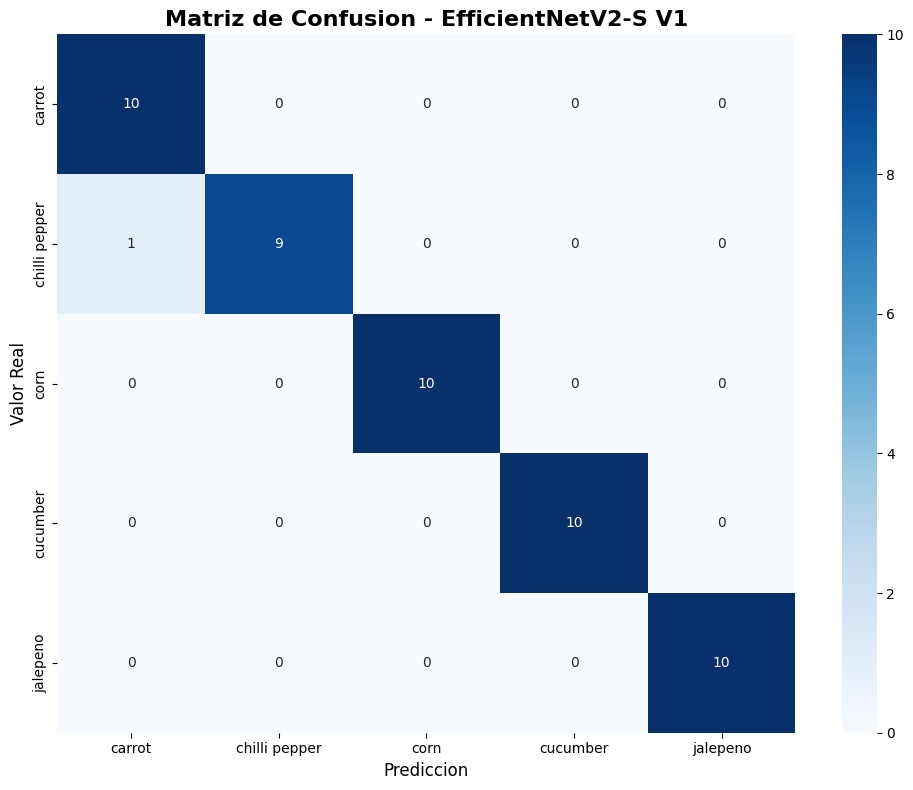


Reporte de Clasificacion:
------------------------------------------------------------
               precision    recall  f1-score   support

       carrot     0.9091    1.0000    0.9524        10
chilli pepper     1.0000    0.9000    0.9474        10
         corn     1.0000    1.0000    1.0000        10
     cucumber     1.0000    1.0000    1.0000        10
     jalepeno     1.0000    1.0000    1.0000        10

     accuracy                         0.9800        50
    macro avg     0.9818    0.9800    0.9799        50
 weighted avg     0.9818    0.9800    0.9799        50



In [9]:
# Evaluacion completa del modelo
print("="*60)
print("EVALUACION FINAL EN CONJUNTO DE TEST")
print("="*60)

test_accuracy, y_true, y_pred = evaluate_model(
    model=trained_model,
    test_loader=test_loader,
    class_names=class_names,
    device=device
)

### 3.6 - Guardado del Modelo Entrenado

In [10]:
# Guardar el modelo entrenado
model_save_path = "efficientnetv2_s_v1.pth"

torch.save({
    'epoch': best_epoch,
    'model_state_dict': trained_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_accuracy': test_accuracy,
    'class_names': class_names,
    'num_classes': num_classes
}, model_save_path)

print(f"Modelo guardado exitosamente en: {model_save_path}")
print(f"Accuracy final en test: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

print("\n" + "="*60)
print("PROYECTO COMPLETADO - EFFICIENTNETV2-S V1")
print("="*60)
print(f"Mejor epoch: {best_epoch}")
print(f"Mejor validation loss: {min(val_losses):.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Clases: {class_names}")
print("="*60)

Modelo guardado exitosamente en: efficientnetv2_s_v1.pth
Accuracy final en test: 0.9800 (98.00%)

PROYECTO COMPLETADO - EFFICIENTNETV2-S V1
Mejor epoch: 10
Mejor validation loss: 0.2010
Test accuracy: 0.9800
Clases: ['carrot', 'chilli pepper', 'corn', 'cucumber', 'jalepeno']


### 3.7 - Funciones para Prediccion de Imagenes Individuales

In [11]:
from utils.predict_images import predict_random_from_test, print_detailed_prediction, predict_single_image, visualize_prediction_result

### 3.8 - Seccion Interactiva de Prediccion

In [12]:
# Seccion interactiva para probar el modelo entrenado

print("="*70)
print("SECCION DE PREDICCION DE IMAGENES INDIVIDUALES")
print("="*70)
print("El modelo ha sido entrenado y esta listo para realizar predicciones")
print(f"Clases disponibles: {class_names}")
print(f"Accuracy del modelo en test: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("="*70)

SECCION DE PREDICCION DE IMAGENES INDIVIDUALES
El modelo ha sido entrenado y esta listo para realizar predicciones
Clases disponibles: ['carrot', 'chilli pepper', 'corn', 'cucumber', 'jalepeno']
Accuracy del modelo en test: 0.9800 (98.00%)



🎲 OPCION 1: Predicciones en imagenes aleatorias del conjunto de test
----------------------------------------------------------------------
Clases disponibles en test: ['corn', 'cucumber', 'jalepeno', 'carrot', 'chilli pepper']

Analizando 3 imagenes aleatorias del conjunto de test...

========================= IMAGEN 1/3 =========================
Clase real: corn
Prediccion: corn (Confianza: 98.85%)
Resultado: ✅ CORRECTA


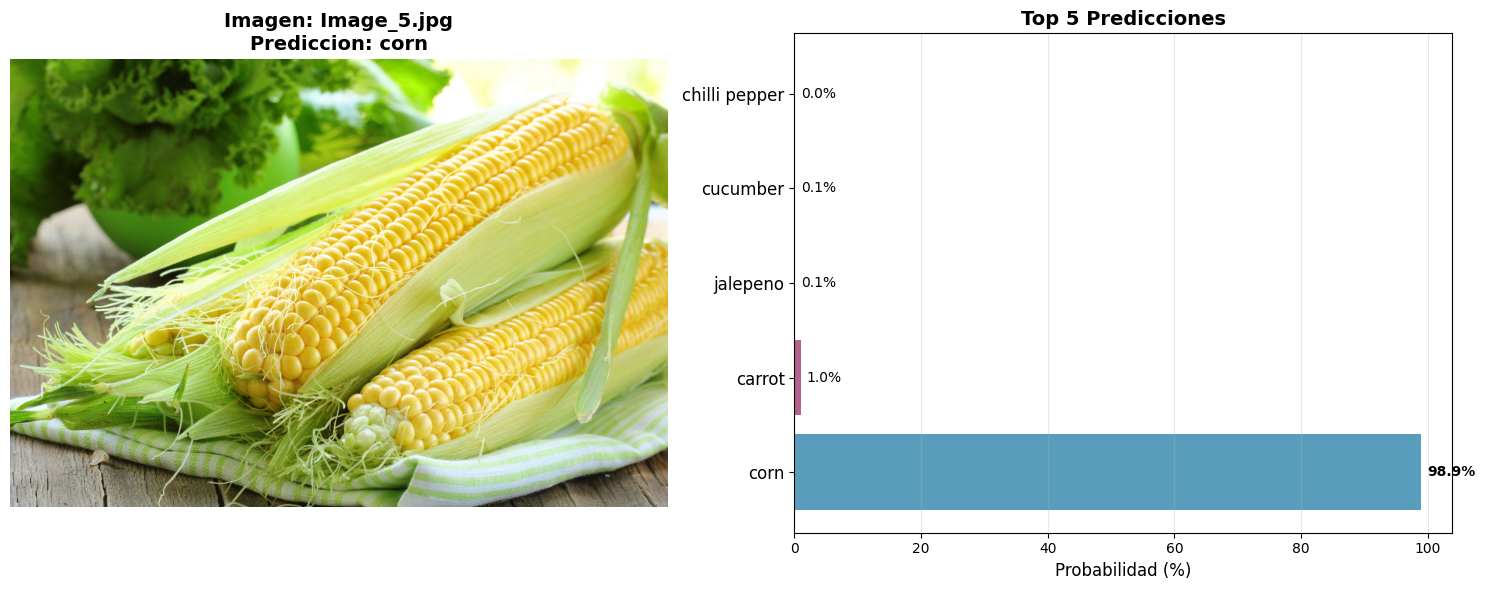


PREDICCION PARA: Image_5.jpg
 1. corn             98.85% ⭐ PREDICCION PRINCIPAL
 2. carrot            0.97% 
 3. jalepeno          0.09% 
 4. cucumber          0.05% 
 5. chilli pepper     0.04% 

========================= IMAGEN 2/3 =========================
Clase real: cucumber
Prediccion: cucumber (Confianza: 54.83%)
Resultado: ✅ CORRECTA


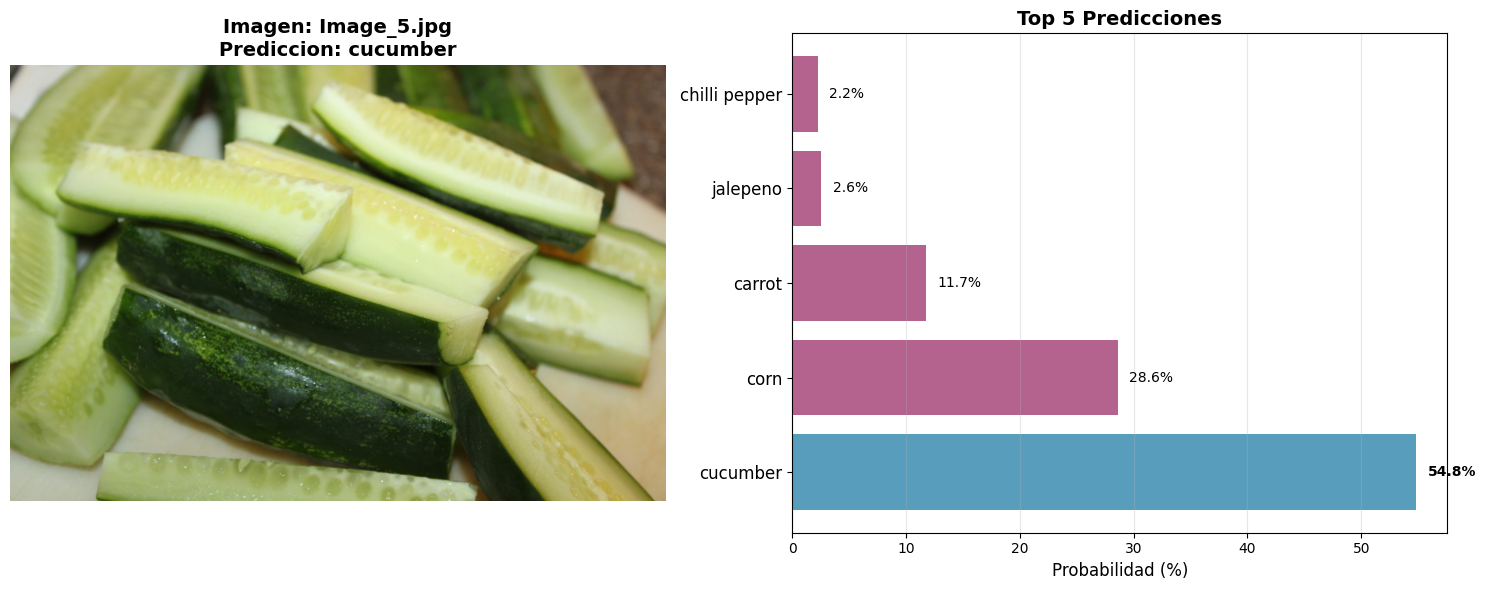


PREDICCION PARA: Image_5.jpg
 1. cucumber         54.83% ⭐ PREDICCION PRINCIPAL
 2. corn             28.63% 
 3. carrot           11.73% 
 4. jalepeno          2.57% 
 5. chilli pepper     2.24% 

========================= IMAGEN 3/3 =========================
Clase real: jalepeno
Prediccion: jalepeno (Confianza: 82.36%)
Resultado: ✅ CORRECTA


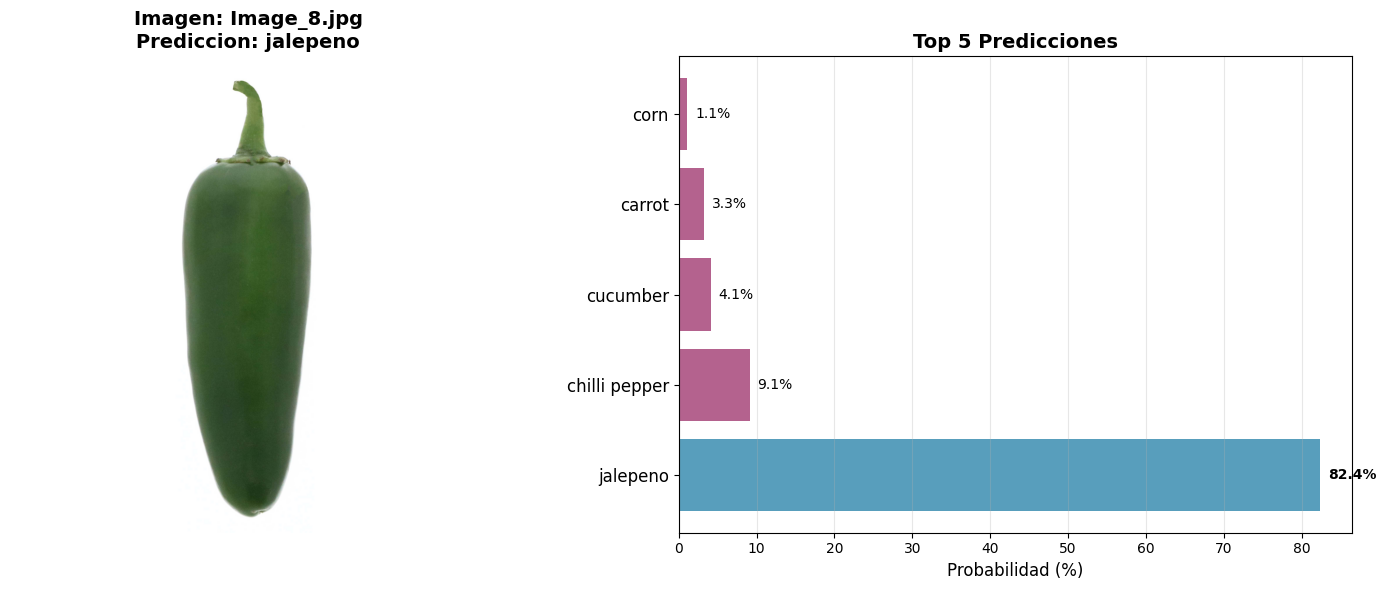


PREDICCION PARA: Image_8.jpg
 1. jalepeno         82.36% ⭐ PREDICCION PRINCIPAL
 2. chilli pepper     9.10% 
 3. cucumber          4.15% 
 4. carrot            3.28% 
 5. corn              1.12% 


In [13]:
# OPCION 1: Prediccion de imagenes aleatorias del conjunto de test
print("\n🎲 OPCION 1: Predicciones en imagenes aleatorias del conjunto de test")
print("-"*70)

test_dataset_path = f"{data_dir}/test"
num_test_samples = 3  # Puedes cambiar este numero

predict_random_from_test(
    model=trained_model,
    test_dataset_path=test_dataset_path,
    class_names=class_names,
    transform=val_test_transform,
    device=device,
    num_samples=num_test_samples
)

In [ ]:
# OPCION 2: Widget interactivo para seleccionar imágenes
print("\n📁 OPCION 2: Selector interactivo de imágenes")
print("-"*70)

try:
    from utils.select_widget_imagen import setup_widget_prediction, display_prediction_widget
    
    # Configurar el widget con las variables del modelo
    setup_widget_prediction(
        model=trained_model,
        transform=val_test_transform,
        classes=class_names,
        device_type=device
    )
    
    # Mostrar el widget
    display_prediction_widget()
    
except ImportError:
    print("❌ Error al importar el widget.")
    print("Verifica que ipywidgets esté instalado:")
    print("pip install ipywidgets")
except Exception as e:
    print(f"❌ Error: {e}")
    print("Usando método alternativo...")


📁 OPCION 2: Selector interactivo de imágenes
----------------------------------------------------------------------
✅ Widget de predicción configurado correctamente!
📋 Instrucciones:
1. Haz clic en 'Seleccionar imagen' abajo
2. Selecciona una imagen desde tu computadora
3. La predicción se mostrará automáticamente

Formatos soportados: JPG, JPEG, PNG, BMP, TIFF
------------------------------------------------------------


FileUpload(value=(), accept='.jpg,.jpeg,.png,.bmp,.tiff', description='📁 Seleccionar imagen')

Output()